In [213]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc

from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signal_power
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

def Gerar_Simbolos(M,nsimbolos,SPS,formatoPulso,nTaps,alpha):
    # Geração de simbolos
    bits = np.random.randint(0,2,int(nsimbolos*np.log2(M)))

    simbolos = modulateGray(bits, M, 'pam')
    simbolos = pnorm(simbolos)

    # Fomartação de pulso
    simbolosup = upsample(simbolos, SPS)
    pulso = pulseShape(formatoPulso, SPS, nTaps, alpha)
    pulso = pulso/max(abs(pulso))
    sinal = firFilter(pulso, simbolosup)
    sinal = sinal.real
    # if formatoPulso == 'rrc':
    #     np.savez('Dados Gerador De sinal/Python/{}PAM_SPS={}_{}_alpha={}.npz'.format(int(M),int(SPS),formatoPulso,alpha), simbolos=simbolos,sinal=sinal)
    # else:
    #     np.savez('Dados Gerador De sinal/Python/{}PAM_SPS={}_{}.npz'.format(int(M),int(SPS),formatoPulso), simbolos=simbolos,sinal=sinal)

    #npz = np.load('{}PAM_SPS={}_{}_aplha={}.npz'.format(int(M),int(SPS),formatoPulso,alpha))
    #print(npz['simbolos'])

    # Geração do arquivo do DAC
    sinal = sinal - np.min(sinal)
    sinal = sinal/np.max(sinal)*65534
    sinal = sinal - 32767
    sinal = (np.rint(sinal)).astype(int)
    return bits,sinal

def Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,filtro):
    pontos = np.array2string(pontos, separator=', ').translate({ord(i): None for i in '[]'}).replace('\n','')

    #DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:CLEar;*OPC?')
    #DAC.read()
    DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,END, {pontos};*OPC?')    
    #DAC.read()
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:SRATe {fs};*OPC?')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:FILTer {filtro};*OPC?')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:APPLy;*OPC?')
    #DAC.read()
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:STATe ON;*OPC?')
    DAC.write(f':SOURce{Porta}:VOLTage:HIGH {V_High};*OPC?')
    DAC.write(f':SOURce{Porta}:VOLTage:LOW {V_Low};*OPC?')
    DAC.write(f':OUTPut{Porta}:STATe ON;*OPC?')
    #DAC.read()

def ConfigurarScope(scope,tempo,canais,vDivisao,impedancia,trigger,offset):
    scope.write('trigger:mode edge')
    scope.write(f'timebase:range {tempo}')
    scope.write(':CHANnel1:DISPlay 0')
    scope.write(':CHANnel2:DISPlay 0')
    scope.write(':CHANnel3:DISPlay 0')
    scope.write(':CHANnel4:DISPlay 0')
    for i in range(len(canais)):
        scope.write(f'trigger:level channel{canais[i]}, {trigger[i]}')
        scope.write(f'channel{canais[i]}:impedance {impedancia[i]}')
        scope.write(f':CHANnel{canais[i]}:OFFSet {offset[i]}')
        scope.write(f'CHANnel{canais[i]}:SCALe {vDivisao[i]}')
        scope.write(f':CHANnel{canais[i]}:DISPlay 1;*OPC?')
    

def AdquirirOnda(scope,canal):
    if canal == 'FFT':
        scope.write(':WAVeform:SOURce FFT')
    else:
        scope.write(f'waveform:source channel{canal}')
    scope.write('waveform:format byte')
    
    dados = scope.query_binary_values('waveform:data?', datatype='B')
    nDados = len(dados)

    tInicial = float(scope.query('waveform:xorigin?'))
    Δt = float(scope.query('waveform:xincrement?'))

    yIncial = float(scope.query('waveform:yorigin?'))
    Δy = float(scope.query('waveform:yincrement?'))
    yReferencia = float(scope.query('waveform:yreference?'))
    
    
    t = np.linspace(tInicial,tInicial + Δt*nDados,nDados,endpoint=0)
    y = (np.array(dados) - yReferencia)*Δy  + yIncial

    return t,y
def ConfigFFT(scope,canal,escaladB,fstart,fstop):
    scope.write(f':FFT:SOURce{canal}')
    scope.write(f':FFT:SCALe {escaladB}')
    scope.write(f':FFT:FREQuency:STARt {fstart}')
    scope.write(f':FFT:FREQuency:STOP {fstop}')
    scope.write(':FFT:DMODe AVERage')
    scope.write(':FFT:DISPlay 1')

In [182]:
DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:SRATe {200000}')

46

In [216]:
DAC.close()
scope.close()
rm.close()


In [218]:
# Conectar
rm = pv.ResourceManager()
print(rm.list_resources())

DAC = rm.open_resource('USB0::0x1AB1::0x0646::DG9R261500165::0::INSTR')
print('info DAC:', DAC.query('*IDN?'))

DAC.write('*rst')
DAC.write('*opc?') 

scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
print('Info Osciloscopio:', scope.query('*IDN?'))
scope.write('*rst')
scope.write('*opc?') 


('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x1AB1::0x0646::DG9R261500165::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
info DAC: RIGOL TECHNOLOGIES,DG922 Pro,DG9R261500165,00.01.00.00.21 

Info Osciloscopio: KEYSIGHT TECHNOLOGIES,DSO-X 3014T,MY55440748,04.06.2015051201



7

In [186]:
Onda_Dac(DAC,Porta,100e3,V_High,V_Low,pontos,filtro)


In [214]:
DAC.write(':ABORt')

8

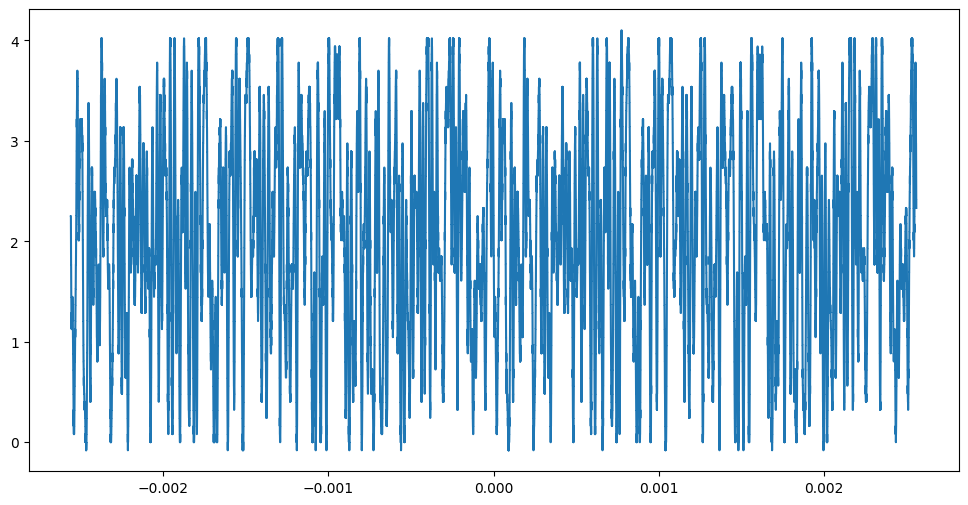

In [222]:
DAC.write('*rst')

#DAC.write('*opc?') 
# scope.write('*rst')
# scope.write('*opc?') 
#Valores Geração do sinal
M = 4 # order of the modulation format
nsimbolos = 512
SPS = 1
formatoPulso = 'rect' #'rect','nrz','rrc'
nTaps = 1024
alpha = 0.1

bits,simbolos = Gerar_Simbolos(M,nsimbolos,SPS,formatoPulso,nTaps,alpha)
#Gerando uma onda arbitraria no DAC
DAC = DAC
Porta = 2
fs = 200e3
V_High = 4
V_Low = 0 
pontos = simbolos
filtro = 'INSert'
filtro = 'NORMAL'

Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,filtro)
#DAC.write('*OPC?')
time.sleep(10)
#Configurar O osciloscopio
tempo = 2*nsimbolos/(fs)
canais = np.array([2])
vDivisao = np.array([2,2])
impedancia = np.array(['ONEMeg ','FIFTy'])
trigger = np.array([0,0])
offset = np.array([0,0])
ConfigurarScope(scope,tempo,canais,vDivisao,impedancia,trigger,offset)
# #Plotar o sinal
scope.write('digitize')
time.sleep(2)
t,y = AdquirirOnda(scope,2)
plt.plot(t,y,label='Sinal porta 2')

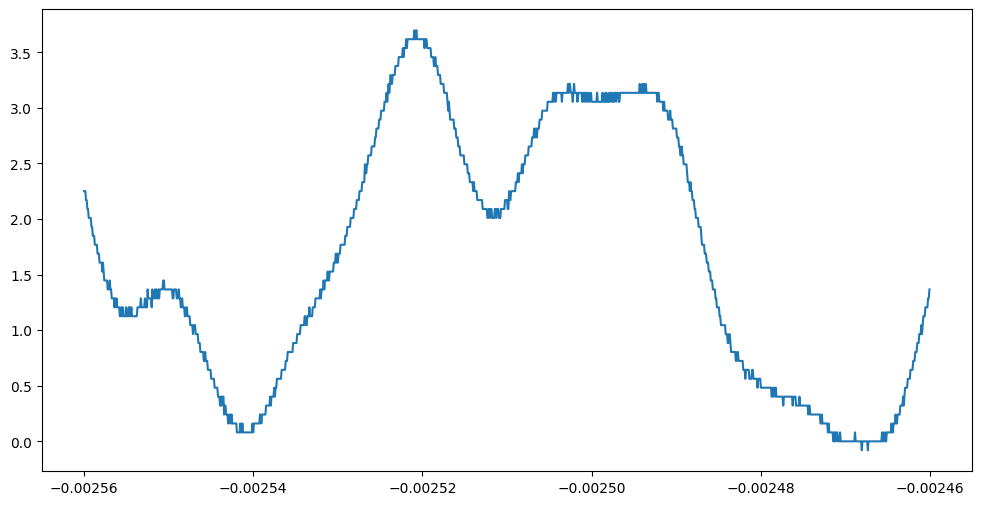

In [223]:
t,y = AdquirirOnda(scope,2)
sps = int(len(t)/(len(simbolos*2)))
Nsimbolos = 10
plt.plot(t[0:sps*Nsimbolos],y[0:sps*Nsimbolos],label='Sinal porta 2')

(-0.075, -0.02)

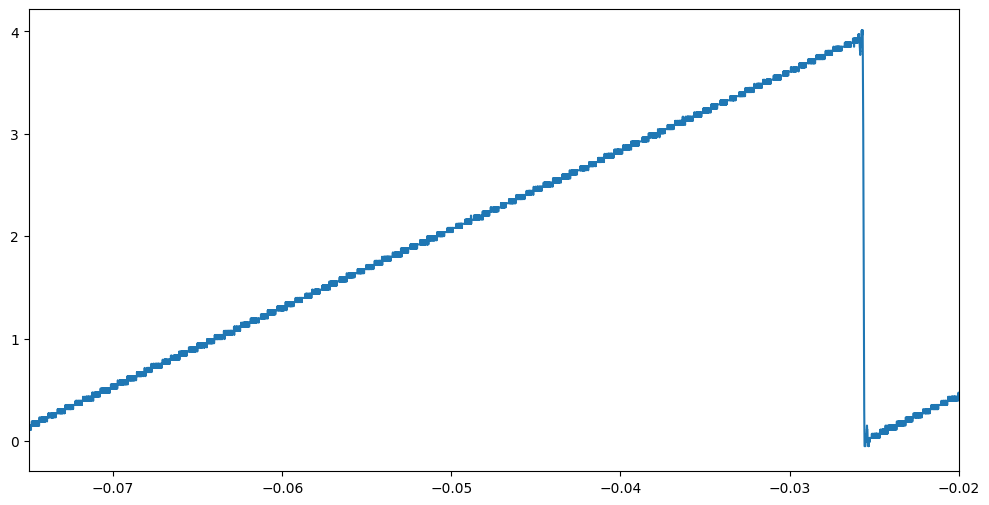

In [96]:
scope.write('digitize')
time.sleep(1)
t,y = AdquirirOnda(scope,2)
plt.plot(t,y,label='Sinal porta 2')
plt.xlim(-0.075,-0.02)